## Create Gym Env

In [1]:
import gymnasium as gym  #
import numpy as np

#定义环境
class MyWrapper(gym.Wrapper):

    def __init__(self):
        _env = gym.make('CarRacing-v2',
                       continuous=True,
                       render_mode='rgb_array')
        super().__init__(_env)
        self.env = _env
        self.step_n = 0

    def reset(self, seed=None, options=None):
        _state, _info = self.env.reset()
        self.step_n = 0
        return _state, _info

    def step(self, action):
        _state, _reward, _done, _truncated, _info = self.env.step(action)
        self.step_n += 1
        if self.step_n >= 400:
            _done = True
        return _state, _reward, _done, _truncated, _info


env = MyWrapper()

In [2]:
print('env.observation_space=', env.observation_space)
print('env.action_space=', env.action_space)

state, _ = env.reset()
action = env.action_space.sample()
next_state, reward, done, truncated, info = env.step(action)


print("state.shape=",state.shape, ", min=", np.min(state), ", max=", np.max(state))
print('action=', action)
print("next_state.shape=",next_state.shape, ", min=", np.min(next_state), ", max=", np.max(next_state))
print('reward=', reward)
print('done=', done)
print('truncated=', truncated)
print('info=', info)

env.observation_space= Box(0, 255, (96, 96, 3), uint8)
env.action_space= Box([-1.  0.  0.], 1.0, (3,), float32)
state.shape= (96, 96, 3) , min= 0 , max= 228
action= [0.44406217 0.27327466 0.89147556]
next_state.shape= (96, 96, 3) , min= 0 , max= 253
reward= 6.917543859649123
done= False
truncated= False
info= {}


## Make Vec Env
矢量化环境是一种将多个独立环境堆叠到单个环境中的方法。它允许我们在每个步骤的环境上训练它，而不是在n每个步骤的 1 个环境上训练 RL 代理。因此，actions传递给环境的现在是一个向量（维度为n）。observations和rewards情节结束信号 ( )的情况相同dones。在非数组观测空间（例如Dict或 ）的情况下Tuple，不同的子空间可能具有不同的形状，子观测值是向量（维度为n）。

see [vecenv-api-vs-gym-api](https://stable-baselines3.readthedocs.io/en/master/guide/vec_envs.html#vecenv-api-vs-gym-api) for more details

In [3]:
from stable_baselines3.common.env_util import make_vec_env

vec_env=make_vec_env(MyWrapper, n_envs=8)
state = vec_env.reset()
print(state.shape)

(8, 96, 96, 3)


In [4]:
import torch
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from gymnasium import spaces

from stable_baselines3.common.preprocessing import get_flattened_obs_dim, is_image_space
from stable_baselines3.common.type_aliases import TensorDict
from stable_baselines3.common.utils import get_device
from typing import Dict, List, Tuple, Type, Union

import gymnasium as gym
import torch as th
from gymnasium import spaces
from torch import nn
#自定义特征抽取层
class NatureCNN(BaseFeaturesExtractor):
    """
    CNN from DQN Nature paper:
        Mnih, Volodymyr, et al.
        "Human-level control through deep reinforcement learning."
        Nature 518.7540 (2015): 529-533.

    :param observation_space:
    :param features_dim: Number of features extracted.
        This corresponds to the number of unit for the last layer.
    :param normalized_image: Whether to assume that the image is already normalized
        or not (this disables dtype and bounds checks): when True, it only checks that
        the space is a Box and has 3 dimensions.
        Otherwise, it checks that it has expected dtype (uint8) and bounds (values in [0, 255]).
    """

    def __init__(
        self,
        observation_space: gym.Space,
        features_dim: int = 512,
        normalized_image: bool = False,
    ) -> None:
        assert isinstance(observation_space, spaces.Box), (
            "NatureCNN must be used with a gym.spaces.Box ",
            f"observation space, not {observation_space}",
        )
        super().__init__(observation_space, features_dim)
        # We assume CxHxW images (channels first)
        # Re-ordering will be done by pre-preprocessing or wrapper
        assert is_image_space(observation_space, check_channels=False, normalized_image=normalized_image), (
            "You should use NatureCNN "
            f"only with images not with {observation_space}\n"
            "(you are probably using `CnnPolicy` instead of `MlpPolicy` or `MultiInputPolicy`)\n"
            "If you are using a custom environment,\n"
            "please check it using our env checker:\n"
            "https://stable-baselines3.readthedocs.io/en/master/common/env_checker.html.\n"
            "If you are using `VecNormalize` or already normalized channel-first images "
            "you should pass `normalize_images=False`: \n"
            "https://stable-baselines3.readthedocs.io/en/master/guide/custom_env.html"
        )
        n_input_channels = observation_space.shape[0]
        self.cnn = nn.Sequential(
            nn.Conv2d(n_input_channels, 32, kernel_size=8, stride=4, padding=0),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2, padding=0),
            nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.Flatten(),
        )

        # Compute shape by doing one forward pass
        with th.no_grad():
            n_flatten = self.cnn(th.as_tensor(observation_space.sample()[None]).float()).shape[1]

        self.linear = nn.Sequential(nn.Linear(n_flatten, features_dim), nn.ReLU())

    def forward(self, observations: th.Tensor) -> th.Tensor:
        return self.linear(self.cnn(observations))

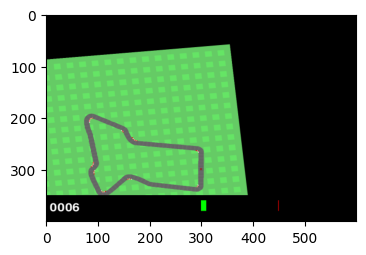

In [5]:
from matplotlib import pyplot as plt

%matplotlib inline

#打印游戏
def show():
    plt.figure(figsize=(4, 4))
    plt.imshow(env.render())
    plt.show()


show()

In [7]:
from stable_baselines3 import DDPG
from stable_baselines3.common.env_util import make_vec_env

#初始化模型
model = DDPG(
    policy='MlpPolicy',
    env=make_vec_env(MyWrapper, n_envs=1),  #使用N个环境同时训练
    learning_rate=1e-3,
    buffer_size=10000,  #replay_buff_size
    learning_starts=100,  #从N步以后开始训练
    batch_size=100,  #一次采样数据量
    tau=0.005,  #target网络每次软更新量
    gamma=0.9,
    train_freq=(20, 'step'),  #训练频率
    verbose=1,
    tensorboard_log="./tensor_board_ddpg_car_racing_v2/",
    policy_kwargs={
                    'features_extractor_class': NatureCNN,
                    'features_extractor_kwargs': {
                        'features_dim': 512
                    },
                }
    )


model

Using cuda device
Wrapping the env in a VecTransposeImage.


In [8]:
from stable_baselines3.common.evaluation import evaluate_policy
evaluate_policy(model, env, n_eval_episodes=2, deterministic=False)

C:\ProgramData\miniconda3\envs\RoadNetOpt\lib\site-packages\stable_baselines3\common\evaluation.py:67: UserWarning: Evaluation environment is not wrapped with a ``Monitor`` wrapper. This may result in reporting modified episode lengths and rewards, if other wrappers happen to modify these. Consider wrapping environment first with ``Monitor`` wrapper.
  warnings.warn(


(7.069432705640793, 2.5488861799240112)

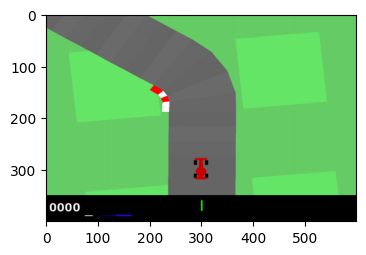

0.4984423676012908 400


In [9]:
from IPython import display
def test():
    state, _ = env.reset()
    reward_sum = []
    over = False
    while not over:
        action, _ = model.predict(state)
        state, reward, over, truncated, _ = env.step(action)
        reward_sum.append(reward)

        if len(reward_sum) % 5 == 0:
            display.clear_output(wait=True)
            show()

    print(sum(reward_sum), len(reward_sum))


test()

In [10]:
#训练
model.learn(10000,
            progress_bar=True)


Logging to ./tensor_board_ddpg_car_racing_v2/DDPG_3


Output()

---------------------------------
| rollout/           |          |
|    ep_len_mean     | 400      |
|    ep_rew_mean     | -30.4    |
| time/              |          |
|    episodes        | 4        |
|    fps             | 101      |
|    time_elapsed    | 15       |
|    total_timesteps | 1600     |
| train/             |          |
|    actor_loss      | 0.0854   |
|    critic_loss     | 0.114    |
|    learning_rate   | 0.001    |
|    n_updates       | 74       |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 400      |
|    ep_rew_mean     | -31.6    |
| time/              |          |
|    episodes        | 8        |
|    fps             | 100      |
|    time_elapsed    | 31       |
|    total_timesteps | 3200     |
| train/             |          |
|    actor_loss      | 0.0117   |
|    critic_loss     | 0.121    |
|    learning_rate   | 0.001    |
|    n_updates       | 154      |
--------------

In [11]:
%load_ext tensorboard

In [13]:
%tensorboard --logdir ./tensor_board_ddpg_car_racing_v2/

Launching TensorBoard...